In [2]:
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
import pandas as pd
import time
import numpy as np, scipy.stats as st

from scipy.stats import norm
from tqdm import tqdm
from pymle.models import CIR, CKLS, OrnsteinUhlenbeck
from pymle.sim.Simulator1D import Simulator1D
from pymle.TransitionDensity import ExactDensity, KesslerDensity, OzakiDensity, EulerDensity, ShojiOzakiDensity
from pymle.fit.AnalyticalMLE import AnalyticalMLE

In [3]:
# Define auxiliary function to find minimal value
def argmin(iterable):
    return min(enumerate(iterable), key=lambda x: x[1])[0]

In [4]:
# Task 1: fit models to interest rate 01.01.1962 - 22.12.2022
# Read data and preprocessing it
df_IR = pd.read_csv('DGS10.csv')
df_IR = df_IR[df_IR['DGS10'] != '.']

# Make valid numerical sample
sample = df_IR['DGS10'].values
sample = [float(sample[i]) for i in range(len(sample))]
sample = np.array(sample)

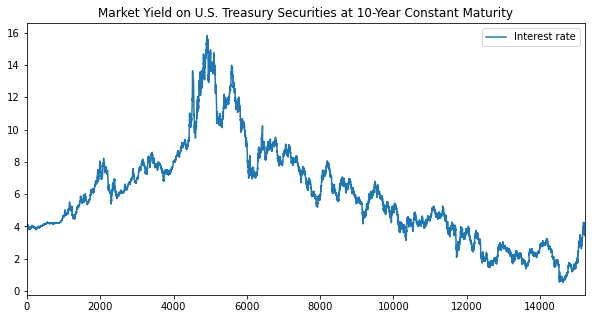

In [5]:
# Plot 
figure, ax = plt.subplots(figsize=(10,5))
ax.plot(np.linspace(0, len(sample), len(sample)),sample, label='Interest rate')
plt.title('Market Yield on U.S. Treasury Securities at 10-Year Constant Maturity')
plt.xlim(0, len(sample))
plt.legend()
plt.show()

In [4]:
# Import models for fitting:
from pymle.models import BrownianMotion, CEV, CIR,\
                         CKLS, GeometricBM, IGBM, \
                         OrnsteinUhlenbeck

In [ ]:
# a) fit using Kessler method:

# Choose several models:
model_name = ["BrownianMotion", "CEV", "CIR", "GeometricBM", \
         "IGBM", "OrnsteinUhlenbeck", "CKLS"] 

model = [BrownianMotion(), CEV(), CIR(), GeometricBM(), \
         IGBM(), OrnsteinUhlenbeck(), CKLS()] 

# Create parametrization templates:
param_bounds = [[(0.01, 10), (0.01, 2)],                         # Brownian Motion
                [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)], # CEV
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # CIR
                [(0.01, 10), (0.01, 2)],                         # GBM
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # IGBM
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # OU
                [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)]  # CKLS
               ]

param_guess  = [[0.01, 0.2],                                     # Brownian Motion
                [0.01, 0.01, 0.01, 0.2],                         # CEV
                [0.01, 0.01, 0.2],                               # CIR
                [0.01, 0.2],                                     # GBM
                [0.01, 0.01, 0.2],                               # IGBM
                [0.01, 0.01, 0.2],                               # OU
                [0.01, 0.01, 0.01, 0.2]                          # CKLS
               ]

# Set parameters for estimators:
dt = 1. / 252

# Estimate max likelyhood, using KesslerDensity
kessler_est   = [AnalyticalMLE(sample, param_bounds[i], dt, density=KesslerDensity(model[i])).estimate_params(param_guess[i]).aic \
               for i in range (len(param_bounds))];
kessler_params   = [AnalyticalMLE(sample, param_bounds[i], dt, density=KesslerDensity(model[i])).estimate_params(param_guess[i]).params \
               for i in range (len(param_bounds))];

In [65]:
best_ind = argmin(kessler_est)
print("AIC values for Kessler estimation:\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      ".format(
     kessler_est[0], model_name[0], kessler_params[0],\
     kessler_est[1], model_name[1], kessler_params[1],\
     kessler_est[2], model_name[2], kessler_params[2],\
     kessler_est[3], model_name[3], kessler_params[3],\
     kessler_est[4], model_name[4], kessler_params[4],\
     kessler_est[5], model_name[5], kessler_params[5],\
     kessler_est[6], model_name[6], kessler_params[6]))

print("The best model is {} \
    with param {}".format(model_name[best_ind], kessler_params[best_ind]))

AIC values for Kessler estimation:
       -39975.989 - BrownianMotion model with params [0.02820138 1.03352921],
       -41606.776 - CEV model with params [0.02011782 0.13874663 0.567096   0.33594728],
       -41068.090 - CIR model with params [0.01107014 0.01003217 0.43970139],
       -33861.192 - GeometricBM model with params [0.01417254 0.24199875],
       -33890.454 - IGBM model with params [0.08735432 8.25039156 0.24173694],
       -39974.495 - OrnsteinUhlenbeck model with params [0.01460372 0.37797492 1.03350969],
       -41605.408 - CKLS model with params [0.0859749  0.02823561 0.57802181 0.32404685],
       
The best model is CEV     with param [0.02011782 0.13874663 0.567096   0.33594728]


In [ ]:
# b) fit using Shoji-Ozaki method:

# Choose several models:
model_name = ["BrownianMotion", "CEV", "CIR", "GeometricBM", \
         "IGBM", "OrnsteinUhlenbeck", "CKLS"] 

model = [BrownianMotion(), CEV(), CIR(), GeometricBM(), \
         IGBM(), OrnsteinUhlenbeck(), CKLS()] 

# Create parametrization templates:
param_bounds = [[(0.01, 10), (0.01, 2)],                         # Brownian Motion
                [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)], # CEV
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # CIR
                [(0.01, 10), (0.01, 2)],                         # GBM
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # IGBM
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # OU
                [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)]  # CKLS
               ]

param_guess  = [[0.01, 0.2],                                     # Brownian Motion
                [0.01, 0.01, 0.01, 0.2],                         # CEV
                [0.01, 0.01, 0.2],                               # CIR
                [0.01, 0.2],                                     # GBM
                [0.01, 0.01, 0.2],                               # IGBM
                [0.01, 0.01, 0.2],                               # OU
                [0.01, 0.01, 0.01, 0.2]                          # CKLS
               ]

# Set parameters for estimators:
dt = 1. / 252
K = 1

# Estimate max likelyhood, using Shoji-Ozaki
shoji_ozaki_est      = [AnalyticalMLE(sample, param_bounds[i], dt, density=ShojiOzakiDensity(model[i])).estimate_params(param_guess[i]).aic \
               for i in range (len(param_bounds))];
shoji_ozaki_params   = [AnalyticalMLE(sample, param_bounds[i], dt, density=ShojiOzakiDensity(model[i])).estimate_params(param_guess[i]).params \
               for i in range (len(param_bounds))];

In [66]:
best_ind = argmin(shoji_ozaki_est)
print("AIC values for Shoji-Ozaki estimation:\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      ".format(
     shoji_ozaki_est[0], model_name[0], shoji_ozaki_params[0],\
     shoji_ozaki_est[1], model_name[1], shoji_ozaki_params[1],\
     shoji_ozaki_est[2], model_name[2], shoji_ozaki_params[2],\
     shoji_ozaki_est[3], model_name[3], shoji_ozaki_params[3],\
     shoji_ozaki_est[4], model_name[4], shoji_ozaki_params[4],\
     shoji_ozaki_est[5], model_name[5], shoji_ozaki_params[5],\
     shoji_ozaki_est[6], model_name[6], shoji_ozaki_params[6]))

print("The best model is {} \
    with param {}".format(model_name[best_ind], shoji_ozaki_params[best_ind]))

AIC values for Shoji-Ozaki estimation:
       -39976.040 - BrownianMotion model with params [0.01020195 1.03352475],
       -41608.974 - CEV model with params [0.01190742 0.6541825  0.57703004 0.32514395],
       -41070.708 - CIR model with params [0.06796725 5.63695691 0.43988463],
       -33870.879 - GeometricBM model with params [0.02983373 0.24229504],
       -33889.449 - IGBM model with params [0.14484645 5.02723773 0.24221546],
       -39974.493 - OrnsteinUhlenbeck model with params [0.0153225  0.38192952 1.03354022],
       -41608.424 - CKLS model with params [0.02275114 0.01000081 0.57692629 0.32523876],
       
The best model is CEV     with param [0.01190742 0.6541825  0.57703004 0.32514395]


In [ ]:
# c) fit using Euler method:

# Choose several models:
model_name = ["BrownianMotion", "CEV", "CIR", "GeometricBM", \
         "IGBM", "OrnsteinUhlenbeck", "CKLS"] 

model = [BrownianMotion(), CEV(), CIR(), GeometricBM(), \
         IGBM(), OrnsteinUhlenbeck(), CKLS()] 

# Create parametrization templates:
param_bounds = [[(0.01, 10), (0.01, 2)],                         # Brownian Motion
                [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)], # CEV
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # CIR
                [(0.01, 10), (0.01, 2)],                         # GBM
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # IGBM
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # OU
                [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)]  # CKLS
               ]

param_guess  = [[0.01, 0.2],                                     # Brownian Motion
                [0.01, 0.01, 0.01, 0.2],                         # CEV
                [0.01, 0.01, 0.2],                               # CIR
                [0.01, 0.2],                                     # GBM
                [0.01, 0.01, 0.2],                               # IGBM
                [0.01, 0.01, 0.2],                               # OU
                [0.01, 0.01, 0.01, 0.2]                          # CKLS
               ]

# Set parameters for estimators:
dt = 1. / 252
K = 1

# Estimate max likelyhood, using Shoji-Ozaki
euler_est   = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).aic \
               for i in range (len(param_bounds))];
eu_params   = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).params \
               for i in range (len(param_bounds))];

In [67]:
best_ind = argmin(euler_est)
print("AIC values for Euler estimation:\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      ".format(
     euler_est[0], model_name[0], eu_params[0],\
     euler_est[1], model_name[1], eu_params[1],\
     euler_est[2], model_name[2], eu_params[2],\
     euler_est[3], model_name[3], eu_params[3],\
     euler_est[4], model_name[4], eu_params[4],\
     euler_est[5], model_name[5], eu_params[5],\
     euler_est[6], model_name[6], eu_params[6]))

print("The best model is {} \
    with param {}".format(model_name[best_ind], eu_params[best_ind]))

AIC values for Euler estimation:
       -39976.040 - BrownianMotion model with params [0.01020182 1.03352475],
       -41611.492 - CEV model with params [0.06504598 5.87897445 0.57674668 0.32538039],
       -41070.711 - CIR model with params [0.0665169  5.73914592 0.43982522],
       -33870.879 - GeometricBM model with params [0.02963357 0.2423094 ],
       -33889.449 - IGBM model with params [0.14456926 5.03477519 0.24214574],
       -39975.780 - OrnsteinUhlenbeck model with params [0.0584254  5.79871441 1.03346573],
       -41608.424 - CKLS model with params [0.02266262 0.01000016 0.57693789 0.32523859],
       
The best model is CEV     with param [0.06504598 5.87897445 0.57674668 0.32538039]


In [70]:
print("For the best model {}\n \
    params are:\n \
    {},\n \
    {},\n \
    {}".format(
    model_name[best_ind],\
    kessler_params[best_ind],\
    shoji_ozaki_params[best_ind],\
    eu_params[best_ind]))

For the best model CEV
     params are:
     [0.02011782 0.13874663 0.567096   0.33594728],
     [0.01190742 0.6541825  0.57703004 0.32514395],
     [0.06504598 5.87897445 0.57674668 0.32538039]


In [8]:
shoji_ozaki_p = [0.01190742, 0.6541825, 0.57703004, 0.32514395]
kessler_p     = [0.02011782, 0.13874663, 0.567096, 0.33594728]
euler_p       = [0.06504598, 5.87897445, 0.57674668, 0.32538039]

In [9]:
# Generate a CEV process with estimated parameters
# Define auxiliary functions:
def Wiener_proc(N, T):
    W = np.zeros(N)  
    delta = T / N
    sqrt_delta = np.sqrt(delta)    
    for i in range (1, N):
        W[i] += W[i-1] + rnd.normal(0, sqrt_delta)
    return W

#  CEV process:
def CEV_pr(S, kappa, mu, sigma, gamma, dt, dW):
    dS = kappa * (mu - S) * dt + sigma * (S**gamma) * dW
    return dS

In [11]:
cW = [sample[i] - sample[i-1] for i in range(1, len(sample))]

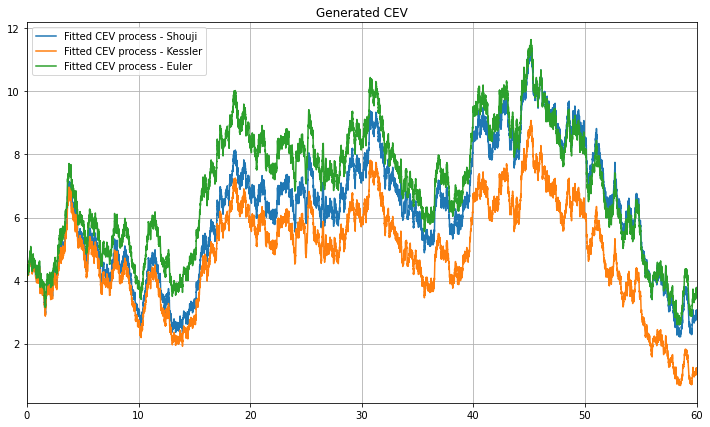

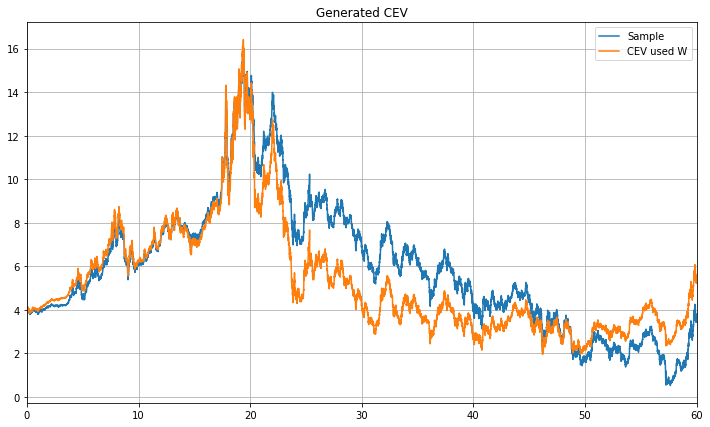

In [13]:
# Set data and generate the process:
T = 60
N = len(sample)

S0 = sample[0]
# Set params that were fitted:
#kappa, mu, sigma, gamma = shoji_ozaki_p
kappa, mu, sigma, gamma = kessler_p
#kappa, mu, sigma, gamma = euler_p
time_line, dt = np.linspace(0, T, N, retstep=True)
W = Wiener_proc(N, T)
cev_s, cev_k, cev_e = np.zeros(N), np.zeros(N), np.zeros(N)
cev_s[0], cev_k[0], cev_e[0] = S0, S0, S0
ecev = np.zeros(N)
ecev[0] = S0

for i in range(1, N):
    dW = W[i] - W[i-1]
    cev_s[i] = cev_s[i-1] + CEV_pr(cev_s[i-1], shoji_ozaki_p[0], shoji_ozaki_p[1], shoji_ozaki_p[2], shoji_ozaki_p[3], dt, dW)
    cev_k[i] = cev_k[i-1] + CEV_pr(cev_k[i-1], kessler_p[0], kessler_p[1], kessler_p[2], kessler_p[3], dt, dW)
    cev_e[i] = cev_e[i-1] + CEV_pr(cev_e[i-1], euler_p[0], euler_p[1], euler_p[2], euler_p[3], dt, dW)
    ecev[i] = ecev[i-1] + CEV_pr(ecev[i-1], euler_p[0], euler_p[1], euler_p[2], euler_p[3], dt, cW[i-1])
    
ax, figure = plt.subplots(figsize=(12, 7))
plt.plot(time_line, cev_s, label="Fitted CEV process - Shouji")
plt.plot(time_line, cev_k, label="Fitted CEV process - Kessler")
plt.plot(time_line, cev_e, label="Fitted CEV process - Euler")
plt.title("Generated CEV")
plt.legend()
plt.xlim(0, T)
plt.grid()
plt.show()

ax, figure = plt.subplots(figsize=(12, 7))
plt.plot(time_line, sample, label="Sample")
plt.plot(time_line, ecev, label='CEV used W')
plt.title("Generated CEV")
plt.legend()
plt.xlim(0, T)
plt.grid()
plt.show()

In [ ]:
# a) fit using Euler method:

# Choose several models:
model = [BrownianMotion(), CEV(), CIR(), GeometricBM(), \
         IGBM(), OrnsteinUhlenbeck(), CKLS()] 

# Create parametrization templates:
param_bounds = [[(0.01, 10), (0.01, 2)],                         # Brownian Motion
                [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)], # CEV
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # CIR
                [(0.01, 10), (0.01, 2)],                         # GBM
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # IGBM
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # OU
                [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)]  # CKLS
               ]

param_guess  = [[0.01, 0.2],                                     # Brownian Motion
                [0.01, 0.01, 0.01, 0.2],                         # CEV
                [0.01, 0.01, 0.2],                               # CIR
                [0.01, 0.2],                                     # GBM
                [0.01, 0.01, 0.2],                               # IGBM
                [0.01, 0.01, 0.2],                               # OU
                [0.01, 0.01, 0.01, 0.2]                          # CKLS
               ]

#pb = param_bounds[0]
#pg = np.array([1., 0.5])
#m = BrownianMotion()

# Set parameters for estimators:
dt = 1. / 252
K = 1
eu_params = []
oz_params = []
so_params = []
ks_params = []
ex_params = []

#euler_est = AnalyticalMLE(sample, param_bounds[0], dt, density=EulerDensity(model[0])).estimate_params(param_guess[0])

for k in tqdm(range(K)):
    seed = rnd.randint(1, 10000)
    euler_est   = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).params \
                 for i in range (len(param_bounds))];
    ozaki_est   = [AnalyticalMLE(sample, param_bounds[i], dt, density=OzakiDensity(model[i])).estimate_params(param_guess[i]).params \
                 for i in range (len(param_bounds))];
    shoji_est   = [AnalyticalMLE(sample, param_bounds[i], dt, density=ShojiOzakiDensity(model[i])).estimate_params(param_guess[i]).params \
                 for i in range (len(param_bounds))];
    kessler_est = [AnalyticalMLE(sample, param_bounds[i], dt, density=KesslerDensity(model[i])).estimate_params(param_guess[i]).params \
                 for i in range (len(param_bounds))];
    exact_est   = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).params \
                 for i in range (len(param_bounds))];
    eu_params.append(euler_est)
    oz_params.append(ozaki_est)
    so_params.append(shoji_est)
    ks_params.append(kessler_est)
    ex_params.append(exact_est)

In [12]:
# Implement multiprocessing approach for solving
import multiprocessing
def MLE_Estimator(i):
    # a) fit using Kessler method:

    # Choose several models:
    model = [BrownianMotion(), CEV(), CIR(), GeometricBM(), \
             IGBM(), OrnsteinUhlenbeck(), CKLS()] 

    # Create parametrization templates:
    param_bounds = [[(0.01, 10), (0.01, 2)],                         # Brownian Motion
                    [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)], # CEV
                    [(0.01, 10), (0.01, 10),(0.01, 2)],              # CIR
                    [(0.01, 10), (0.01, 2)],                         # GBM
                    [(0.01, 10), (0.01, 10),(0.01, 2)],              # IGBM
                    [(0.01, 10), (0.01, 10),(0.01, 2)],              # OU
                    [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)]  # CKLS
                   ]

    param_guess  = [[0.01, 0.2],                                     # Brownian Motion
                    [0.01, 0.01, 0.01, 0.2],                         # CEV
                    [0.01, 0.01, 0.2],                               # CIR
                    [0.01, 0.2],                                     # GBM
                    [0.01, 0.01, 0.2],                               # IGBM
                    [0.01, 0.01, 0.2],                               # OU
                    [0.01, 0.01, 0.01, 0.2]                          # CKLS
                   ]

    #pb = param_bounds[0]
    #pg = np.array([1., 0.5])
    #m = BrownianMotion()

    # Set parameters for estimators:
    dt = 1. / 252
    K = 1
    eu_params = []
    oz_params = []
    so_params = []
    ks_params = []
    ex_params = []

    #euler_est = AnalyticalMLE(sample, param_bounds[0], dt, density=EulerDensity(model[0])).estimate_params(param_guess[0])

    for k in tqdm(range(K)):
        seed = rnd.randint(1, 10000)
        euler_est   = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).params \
                     for i in range (len(param_bounds))];
        ozaki_est   = [AnalyticalMLE(sample, param_bounds[i], dt, density=OzakiDensity(model[i])).estimate_params(param_guess[i]).params \
                     for i in range (len(param_bounds))];
        shoji_est   = [AnalyticalMLE(sample, param_bounds[i], dt, density=ShojiOzakiDensity(model[i])).estimate_params(param_guess[i]).params \
                     for i in range (len(param_bounds))];
        kessler_est = [AnalyticalMLE(sample, param_bounds[i], dt, density=KesslerDensity(model[i])).estimate_params(param_guess[i]).params \
                     for i in range (len(param_bounds))];
        exact_est   = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).params \
                     for i in range (len(param_bounds))];
        eu_params.append(euler_est)
        oz_params.append(ozaki_est)
        so_params.append(shoji_est)
        ks_params.append(kessler_est)
        ex_params.append(exact_est)
    return [eu_params,
            oz_params,
            so_params,
            ks_params,
            ex_params]

In [ ]:
# Run estimator with parallel calculating:
K = 100
i_range   = [i for i in range(100)]
pool_obj = multiprocessing.Pool()
answer = pool_obj.map(MLE_Estimator, i_range)